# Ames Housing - Interpretable ML
- Author: Oliver Mueller
- Last update: 26.01.2024

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [81]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap

In [4]:
plt.style.use('fivethirtyeight')

## Problem description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 76 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. More: <https://www.kaggle.com/c/house-prices-advanced-regression-techniques>


## Load data

Load training data from CSV file.

In [5]:
data = pd.read_csv('data/train.csv')

In [6]:
data.head()

,house_id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,80,10400,Pave,none,Reg,Lvl,AllPub,...,0,0,0,MnPrv,0,6,2009,WD,Family,152000
1,2,60,RL,0,28698,Pave,none,IR2,Low,AllPub,...,0,225,0,none,0,6,2009,WD,Abnorml,185000
2,3,90,RL,70,9842,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,3,2007,WD,Normal,101800
3,4,90,RL,60,7200,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,6,2009,WD,Normal,90000
4,5,190,RM,63,7627,Pave,none,Reg,Lvl,AllPub,...,0,0,0,none,0,10,2009,WD,Normal,94550


In [7]:
data.shape

(2344, 78)

In [8]:
data.columns

Index(['house_id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', '

## Prepare data

Let us first focus on some easy to understand variables.

In [9]:
data = data[["SalePrice", "LotArea", "GrLivArea", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "OverallQual", "OverallCond"]]

In [10]:
data.head()

,SalePrice,LotArea,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,OverallQual,OverallCond
0,152000,10400,1370,2,3,1,7,5
1,185000,28698,2126,2,3,1,5,5
2,101800,9842,1224,2,2,2,4,5
3,90000,7200,1040,2,2,2,4,5
4,94550,7627,1701,2,4,2,4,6


Finally, we will split the data into features (*X*) and labels (*y*) and into training (*X_train, y_train*) and test (*X_test, y_test*) sets.

In [11]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fit a Random Forest model

Since, we are mainly interested in interpreting the model, we will skip feature engineering and hyperparameter tuning and directly jump to fitting a Random Forest model to the trainig data.

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [15]:
pred = rf_model.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
print(rmse)

27216.347608293938


The RMSE is not super great, but that is not the main focus of this analysis, as we are interested in interpreting the model. Still, as we can see below, the Random Forest performs much better as linear regression.

In [17]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
print(rmse)

33176.302645425174


## Global explanations: Permutation-based feature importance

Use `permutation_importance` as model-agnostic function to calculate feature importance.

In [19]:
r = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

Iterate over the results and put them into a dataframe for easier manipulation and plotting.

In [34]:
importances = []
for i in r.importances_mean.argsort():
    entry = {}
    entry['feature'] = rf_model.feature_names_in_[i]
    entry['value'] = r.importances_mean[i]
    entry['std'] = r.importances_std[i]
    importances.append(entry)

Sor the dataframe by the mean importance and print it.

In [42]:
importances = pd.DataFrame(importances).sort_values(by='value', ascending=False)
importances.head(10)

,feature,value,std
6,OverallQual,0.839415,0.024223
5,GrLivArea,0.345479,0.013004
4,LotArea,0.145249,0.005518
3,FullBath,0.047743,0.002730
2,BedroomAbvGr,0.038725,0.001989
1,OverallCond,0.029539,0.001869
0,KitchenAbvGr,0.002969,0.000417


Plot the results as a bar plot.

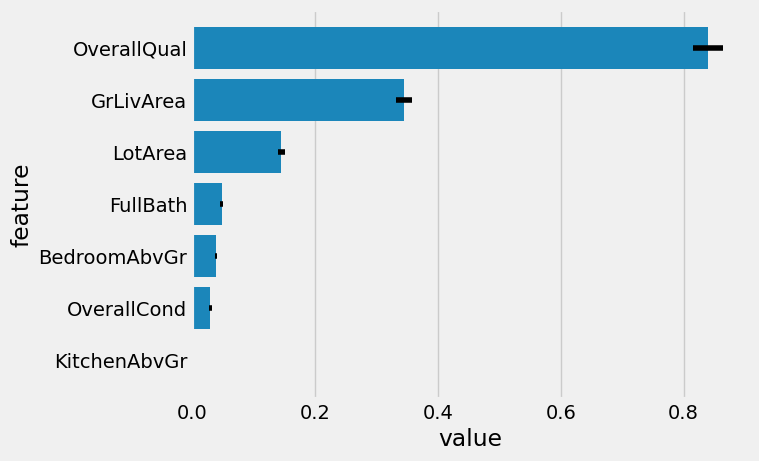

In [66]:
sns.barplot(data=importances, x='value', y='feature')
plt.errorbar(data=importances, x='value', y='feature', xerr='std', fmt='none', color='black')
plt.show()

## Global explanations: Partial dependence plots (PDP)

Next, we explore the partial dependence of the response on the features.

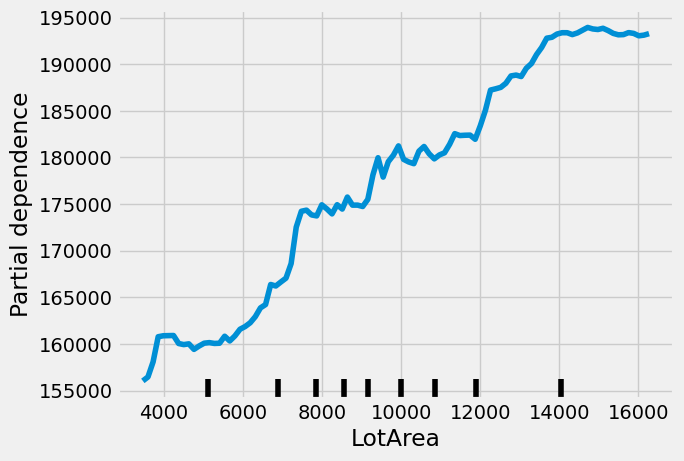

In [75]:
features = ["LotArea"]
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=features)

We can also create 2D partial dependence plots to explore possible interactions between features.

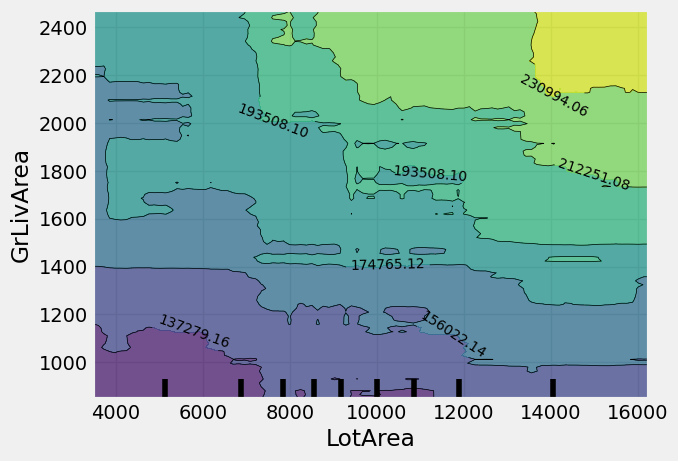

In [74]:
features = [("LotArea", "GrLivArea")]
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=features)

In [ ]:
features = ["LotArea"]
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=features)

## Local explanations: Individual conditional expectation (ICE) plots

ICE plots are the equivalent of partial dependence plots for individual observations.

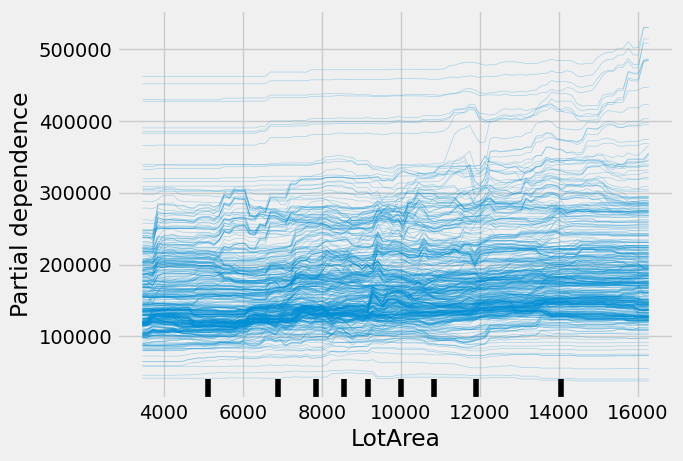

In [79]:
features = ["LotArea"]
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=features, kind='individual')

## Local explanations: SHAP values

Finally, we will calculate SHAP values to explain single predictions from the test set. As we have fitted a Random Forest model, we will use the fast `TreeExplainer` to calculate SHAP values. There are other methods available for other types of learners (e.g., Neural Networks).

In [116]:
shap.initjs()
explainer = shap.TreeExplainer(rf_model, X_test)

Let's focus on the first house in the test set.

In [119]:
obs = 0
X_test.iloc[obs, :]

LotArea         17808
GrLivArea        1242
FullBath            1
BedroomAbvGr        2
KitchenAbvGr        1
OverallQual         4
OverallCond         5
Name: 1797, dtype: int64

Using the above initiqlized `explainer` object, we will now calcualte SHAP values for all houses in the test set (to be able to compare the predictecd price of an individual house with the average prediction over all houses).

In [121]:
shap_values = explainer(X_test)

Next, we plot the computed SHAP values for the first house as a `waterfall` plot

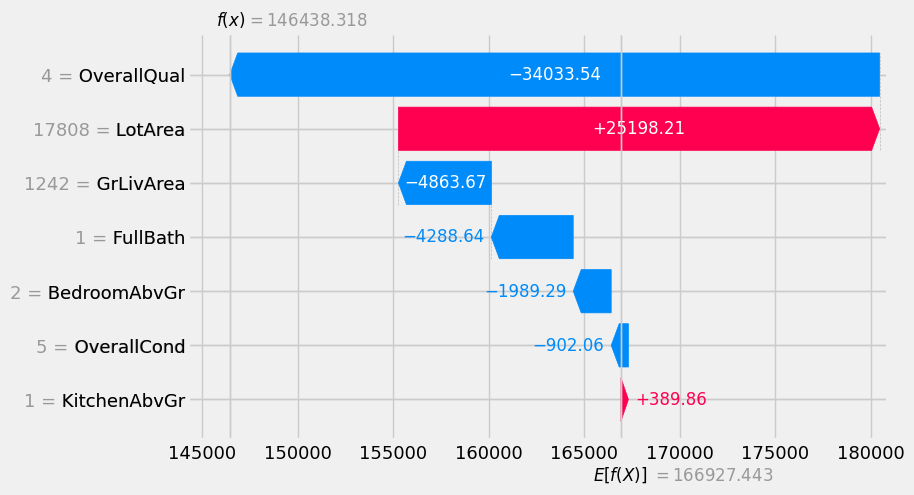

In [122]:
shap.plots.waterfall(shap_values[obs])

The excellent `SHAP` (https://shap.readthedocs.io) package provides many more plots to visualize individual SHAP values and functions to aggregate local SHAP values to global SHAP values.